In [1]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats as qs
import backtrader.indicators as btind

In [2]:
import pandas as pd
nifty_1day = pd.read_csv('../reliance_daily_continous.csv')
nifty_1day['datetime'] =  pd.to_datetime(nifty_1day['datetime'], infer_datetime_format=True)
nifty_1day = nifty_1day.set_index("datetime")
nifty_1day = nifty_1day[nifty_1day.index >= '2011-01-03']
nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['abs_returns'].cumsum()
nifty_1day["cumulative_returns"] = ((1 + nifty_1day["pct_returns"]).cumprod() - 1)+1
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


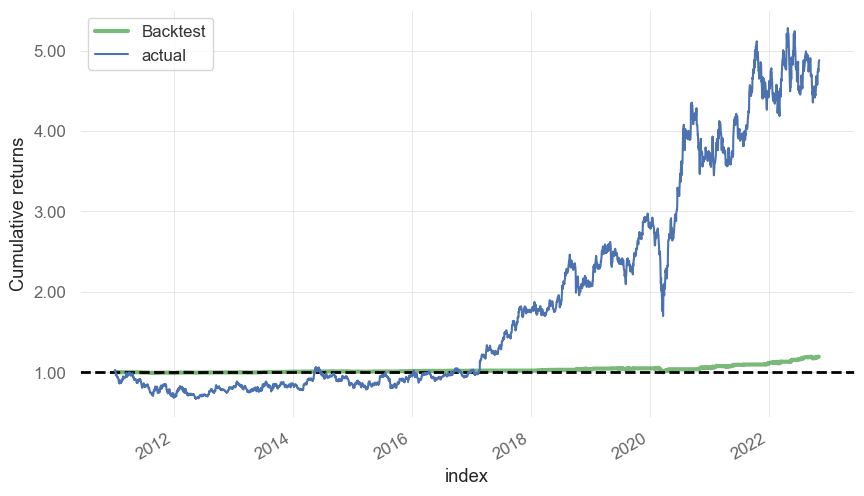

In [4]:
# Create a Stratey
class MeanReversion(bt.Strategy):
    params = (
        ('period', 100),
        ('deviation', 2),
        ('trail_percent', 0.03),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.period
        )
        self.order = None
        self.stop_price = None

    def next(self):
        if not self.position:
            if self.data.close < self.sma[0] - self.params.deviation:
                self.order = self.buy()
                self.stop_price = self.data.close * (1 - self.params.trail_percent)
        else:
            if self.data.close > self.sma[0] + self.params.deviation:
                self.close()
                self.order = None
                self.stop_price = None
            elif self.data.close < self.stop_price:
                self.close()
                self.order = None
                self.stop_price = None
            else:
                self.stop_price = self.data.close * (1 - self.params.trail_percent)
                
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceCSVData(
        dataname='../reliance_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

cerebro.adddata(data)
cerebro.addstrategy(MeanReversion)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Mean Reversal')

'''data = cerebro.plot()
data[0][0].savefig("mean_reversal.png")'''

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("actual_vs_meanreversal.png")